In [227]:
import numpy as np
import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, metrics, preprocessing, naive_bayes, svm
from scipy import sparse
import re
import xgboost
import matplotlib.pyplot as plt

In [114]:
def remove_urls(array):
    pattern = re.compile("https?:\S*")
    return [pattern.sub('',e) for e in array]

In [330]:
def remove_numbers(array):
    pattern = re.compile("\d*")
    return [pattern.sub('',e) for e in array]

In [ ]:
def remove_emoji(array):
    

In [333]:
DATA_TEST = 'test.csv'
DATA_TRAIN = 'train.csv'
SAMPLE_SUBMISSION ='sample_submission.csv'
OUT_DATA = 'res.csv'

In [334]:
train_data = pd.read_csv(DATA_TRAIN)
test_data = pd.read_csv(DATA_TEST)
res = pd.read_csv(SAMPLE_SUBMISSION)

In [335]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [336]:
train_data[train_data['target'] == 0]

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0
...,...,...,...,...,...
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0
7582,10834,wrecked,NaN,Cramer: Iger's 3 words that wrecked Disney's s...,0
7584,10837,NaN,NaN,These boxes are ready to explode! Exploding Ki...,0
7587,10841,NaN,NaN,Sirens everywhere!,0


# Linear model with CountVectorizer

In [337]:
model = linear_model.RidgeClassifier()

In [338]:
count_vectorizer = feature_extraction.text.CountVectorizer(stop_words='english')
train_x = remove_urls(train_data['text'])
train_x = remove_numbers(train_x)
train_x = count_vectorizer.fit_transform(train_x)
train_y = train_data['target']

In [339]:
scores = model_selection.cross_validate(model,
                                        train_x,
                                        train_y,
                                        cv=3,
                                        scoring=['f1','precision', 'recall'])

In [340]:
scores

{'fit_time': array([0.0668385 , 0.05345464, 0.05132341]),
 'score_time': array([0.00498652, 0.0059824 , 0.0039916 ]),
 'test_f1': array([0.57715214, 0.51996008, 0.605     ]),
 'test_precision': array([0.70502646, 0.57002188, 0.66483516]),
 'test_recall': array([0.48854262, 0.47798165, 0.55504587])}

In [148]:
model.fit(train_x, train_y)
pred = model.predict(count_vectorizer.transform(test_data['text']))
res['target'] = pred
res.to_csv(OUT_DATA, index=False)

In [149]:
test_data['target'] = res['target']
test_data

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,1


# Linear model with TFIDF

In [368]:
model = linear_model.RidgeClassifier()

In [369]:
tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(stop_words='english')
train_x = remove_urls(train_data['text'])
train_x = remove_numbers(train_x)
train_x = tfidf_vectorizer.fit_transform(train_x)
train_y = train_data['target']
test_x = tfidf_vectorizer.transform(test_data['text'])

In [364]:
ohe = preprocessing.OneHotEncoder(handle_unknown='ignore')
ohe.fit(test_data['keyword'].fillna('').to_numpy()[:,np.newaxis])
keyword_train_x = ohe.transform(train_data['keyword'].fillna('').to_numpy()[:, np.newaxis])
keyword_test_x = ohe.transform(test_data['keyword'].fillna('').to_numpy()[:, np.newaxis])

In [365]:
train_x = sparse.hstack((train_x, keyword_train_x))
test_x = sparse.hstack((test_x, keyword_test_x))

In [370]:
scores = model_selection.cross_validate(model,
                                        train_x,
                                        train_y,
                                        cv=3,
                                        scoring=['f1','precision', 'recall'])

In [371]:
scores

{'fit_time': array([0.02592683, 0.02694416, 0.01946926]),
 'score_time': array([0.00598574, 0.00796294, 0.00498796]),
 'test_f1': array([0.59077974, 0.54505735, 0.64566929]),
 'test_precision': array([0.77927928, 0.6734143 , 0.75460123]),
 'test_recall': array([0.47571036, 0.45779817, 0.56422018])}

In [346]:
model.fit(train_x, train_y)
pred = model.predict(test_x)
res['target'] = pred
res.to_csv(OUT_DATA, index=False)

In [347]:
test_data['target'] = res['target']
test_data

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,1


# GausianNB with TfIdf

In [ ]:
model = naive_bayes.GaussianNB()

In [222]:
tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(stop_words='english')
train_x = tfidf_vectorizer.fit_transform(remove_urls(train_data['text'])).toarray()
train_y = train_data['target']
test_x = tfidf_vectorizer.transform(test_data['text'])

In [223]:
scores = model_selection.cross_validate(model,
                                        train_x,
                                        train_y,
                                        cv=3,
                                        scoring=['f1','precision', 'recall'])

In [224]:
scores

{'fit_time': array([2.50523067, 2.34651375, 2.58713579]),
 'score_time': array([1.03424954, 1.12293863, 1.10602283]),
 'test_f1': array([0.48252688, 0.40162822, 0.57791045]),
 'test_precision': array([0.90428212, 0.77083333, 0.82735043]),
 'test_recall': array([0.32905591, 0.27155963, 0.4440367 ])}

In [216]:
model.fit(train_x, train_y)
pred = model.predict(test_x.toarray())
res['target'] = pred
res.to_csv(OUT_DATA, index=False)

In [217]:
test_data['target'] = res['target']
test_data

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,0
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,0


In [380]:
custom_vec = feature_extraction.text.TfidfVectorizer(ngram_range=(1,1), stop_words='english')
custom_vec = custom_vec.fit(remove_urls(train_data['text']))
train_x = custom_vec.transform(remove_numbers(remove_urls(train_data['text'])))

In [381]:
index_to_term = dict([(v,k) for k,v in custom_vec.vocabulary_.items()])

In [382]:
custom_vec.vocabulary_

{'deeds': 4205,
 'reason': 12136,
 'earthquake': 4953,
 'allah': 1021,
 'forgive': 6010,
 'forest': 6001,
 'near': 10214,
 'la': 8533,
 'ronge': 12674,
 'sask': 12947,
 'canada': 2727,
 'residents': 12395,
 'asked': 1422,
 'shelter': 13318,
 'place': 11347,
 'notified': 10459,
 'officers': 10622,
 'evacuation': 5377,
 'orders': 10798,
 'expected': 5467,
 '13': 91,
 '000': 1,
 'people': 11152,
 'receive': 12157,
 'wildfires': 16237,
 'california': 2684,
 'just': 8191,
 'got': 6535,
 'sent': 13180,
 'photo': 11246,
 'ruby': 12761,
 'alaska': 972,
 'smoke': 13651,
 'pours': 11534,
 'school': 13024,
 'rockyfire': 12630,
 'update': 15609,
 'hwy': 7361,
 '20': 191,
 'closed': 3287,
 'directions': 4504,
 'lake': 8557,
 'county': 3720,
 'cafire': 2655,
 'flood': 5903,
 'disaster': 4526,
 'heavy': 6969,
 'rain': 12004,
 'causes': 2894,
 'flash': 5867,
 'flooding': 5905,
 'streets': 14190,
 'manitou': 9269,
 'colorado': 3414,
 'springs': 13947,
 'areas': 1312,
 'hill': 7075,
 'woods': 16362,
 'e

In [317]:
def is_useful(feature, target):
    cond = feature > 0
    return any(target[cond])

In [383]:
useful_features = [i for i in range(train_x.shape[1])if is_useful(train_x.getcol(i).toarray()[:,0],train_y)]

In [384]:
print(len(useful_features), train_x.shape)

8160 (7613, 16761)


In [385]:
[(index_to_term[i],i) for i in useful_features]

[('__', 594),
 ('_ashj', 599),
 ('_edvinnn', 608),
 ('_freemarketeer', 610),
 ('_gaabyx', 611),
 ('_jeesss_', 615),
 ('_minimehh', 617),
 ('aa', 636),
 ('aaaaaaallll', 638),
 ('aaaaaand', 639),
 ('aaarrrgghhh', 640),
 ('aan', 642),
 ('aashiqui', 646),
 ('aba', 648),
 ('abandon', 649),
 ('abandoned', 650),
 ('abbswinston', 656),
 ('abbyairshow', 657),
 ('abc', 658),
 ('abcnews', 663),
 ('abcnorio', 665),
 ('abe', 666),
 ('aberystwyth', 670),
 ('abha', 671),
 ('abia', 672),
 ('ability', 673),
 ('ablaze', 675),
 ('able', 676),
 ('ableg', 677),
 ('abninfvet', 678),
 ('aboard', 679),
 ('abomb', 680),
 ('abortion', 682),
 ('abouts', 684),
 ('abs', 687),
 ('absence', 688),
 ('absolute', 690),
 ('absolutely', 691),
 ('abstorm', 692),
 ('absurd', 694),
 ('abuse', 697),
 ('abused', 698),
 ('abuses', 699),
 ('abusing', 700),
 ('acc', 706),
 ('accept', 707),
 ('accepte', 708),
 ('accident', 711),
 ('accidentally', 712),
 ('accidents', 715),
 ('accionempresa', 716),
 ('according', 718),
 ('account'

[0.29977511 0.32535547]


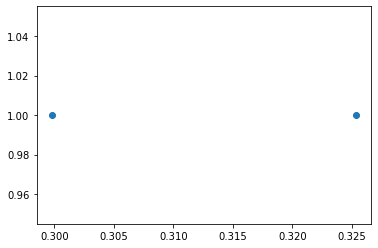

In [387]:
f1 = train_x.getcol(1012).toarray()[:,0]
cond = (f1 > 0) 
f1 = f1[cond]
t = train_y[cond]
print(f1[f1 > 0])
plt.scatter(f1, t)